# Homework 02: Multi-Class Classification with Neural Networks

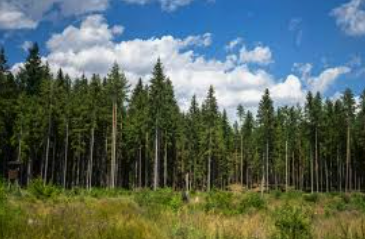

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [6]:
# Useful imports

%pip install pandas
%pip install matplotlib seaborn
%pip install scikit-learn matplotlib seaborn 
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages 


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 23.9 MB/s  0:00:12m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 53.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.5 MB/s  0:00:00
   ━━━━━

2026-02-05 16:34:46.926957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-05 16:34:48.428385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-05 16:34:50.566990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


$$k\cdot\sigma$$

In [1]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}') 

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub)) 


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [5]:
# Your code here

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
random_seed = 42


# 1) Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    random_state=random_seed,
    stratify=y_sub
)

# 2) Standardize features (fit on train only!)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print("Train shape:", X_train.shape, Counter(y_train))
print("Test shape: ", X_test.shape, Counter(y_test)) 

Train shape: (15383, 54) Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test shape:  (3846, 54) Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3600 - loss: 1.7044
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5472 - loss: 1.2520
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5881 - loss: 1.0498
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6157 - loss: 0.9539
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6378 - loss: 0.8966
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6563 - loss: 0.8558
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6743 - loss: 0.8251
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6817 - loss: 0.8009
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6902 - loss: 0.7808
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6944 - loss: 0.7639
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6997 - loss: 0.7495
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

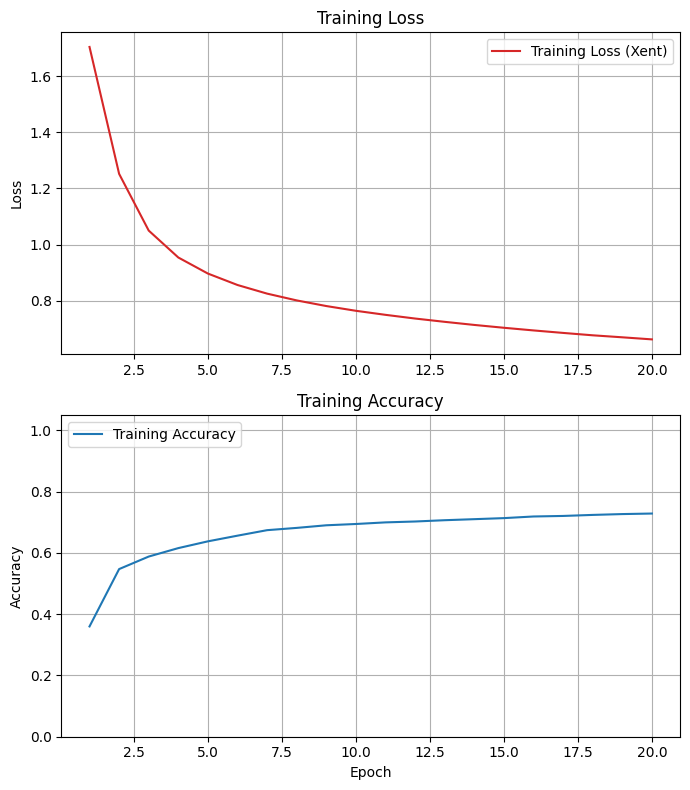

Final Training Loss:     0.6620
Final Training Accuracy: 0.7285


In [7]:
# Your code here

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt 

# Build the model: input -> 64 -> 32 -> output(7)
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train (20 epochs, batch_size=32)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate training (plots + final metrics printout)
plot_history(history) 

In [8]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.7285 

In [9]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7285


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


===== Training with batch_size = 4 =====
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4943 - loss: 1.3268
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6287 - loss: 0.8890
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6627 - loss: 0.8066
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6867 - loss: 0.7593
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7006 - loss: 0.7250
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7123 - loss: 0.6980
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7220 - loss: 0.6752
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7292 - loss: 0.6561
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7373 - loss: 0.6394
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7437 - loss: 0.6241
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7474 - l

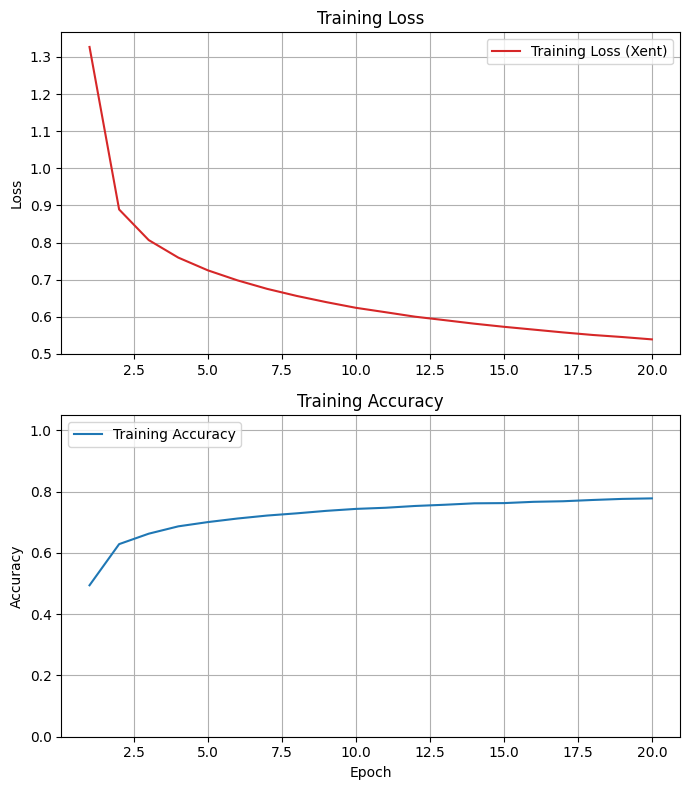

Final Training Loss:     0.5391
Final Training Accuracy: 0.7780

===== Training with batch_size = 8 =====
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4524 - loss: 1.5273
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6181 - loss: 0.9810
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6571 - loss: 0.8515
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6811 - loss: 0.7967
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6952 - loss: 0.7605
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7014 - loss: 0.7338
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7099 - loss: 0.7116
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7173 - loss: 0.6926
Epoch 9/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7235 - loss: 0.6767
Epoch 10/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7268 - loss: 0.6631
Epoch 11/20
1

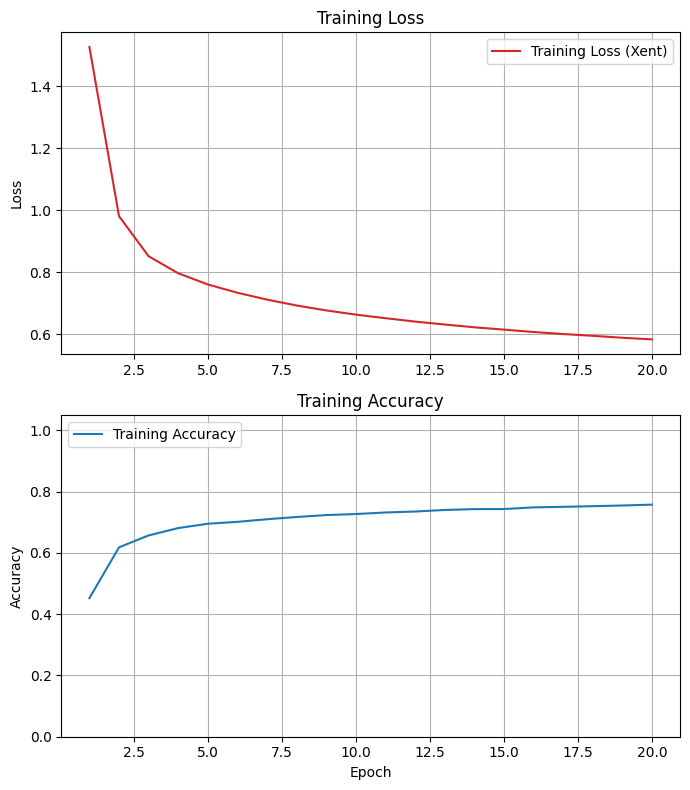

Final Training Loss:     0.5832
Final Training Accuracy: 0.7577

===== Training with batch_size = 16 =====
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4002 - loss: 1.5873
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5927 - loss: 1.0823
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6263 - loss: 0.9157
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6511 - loss: 0.8480
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6652 - loss: 0.8100
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6752 - loss: 0.7823
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6873 - loss: 0.7607
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6982 - loss: 0.7422
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7042 - loss: 0.7257
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7097 - loss: 0.7115
Epoch 11/20
962/962 ━━━━━━━━━━━━

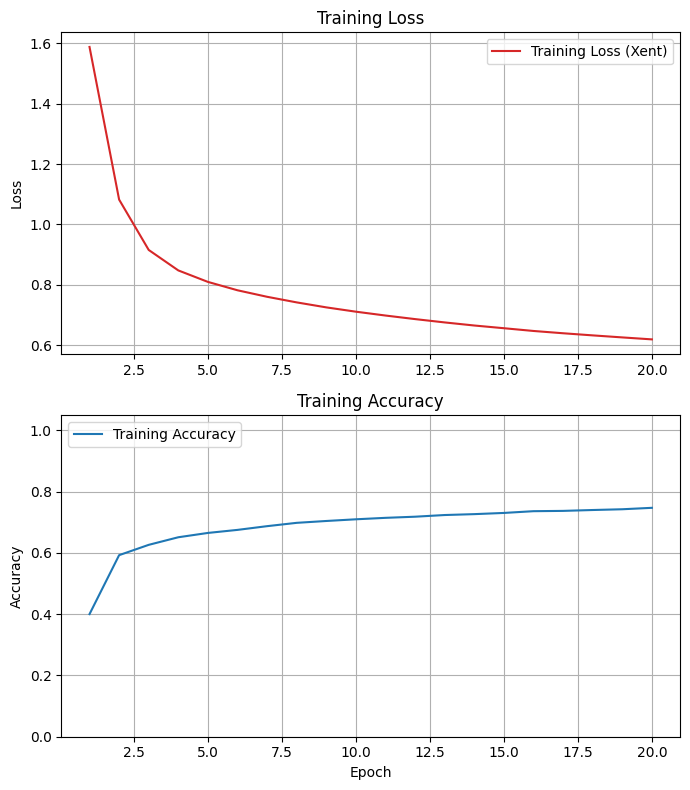

Final Training Loss:     0.6198
Final Training Accuracy: 0.7472

===== Training with batch_size = 128 =====
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1902 - loss: 1.9248
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3804 - loss: 1.6716
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4993 - loss: 1.4676
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5399 - loss: 1.2987
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5628 - loss: 1.1714
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5838 - loss: 1.0800
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6049 - loss: 1.0142
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6159 - loss: 0.9652
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 0.9281
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 0.8990
Epoch 11/20
121/121 ━━━━━━━━━━━

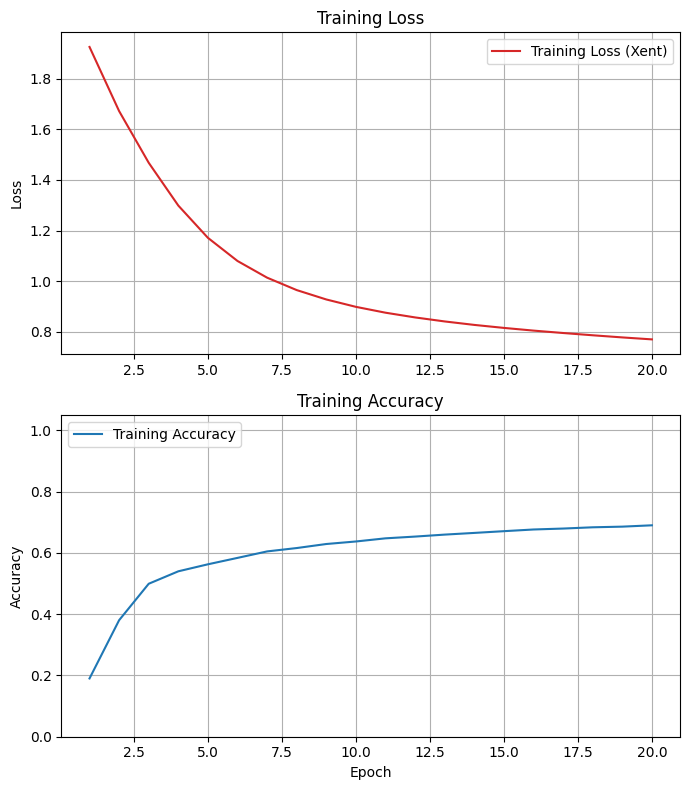

Final Training Loss:     0.7706
Final Training Accuracy: 0.6901


In [10]:
# Your code here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

batch_sizes = [4, 8, 16, 128]
histories = {}   

for bs in batch_sizes:
    tf.keras.backend.clear_session()  

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile (same as Problem 1)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== Training with batch_size = {bs} =====")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        verbose=1
    )

    histories[bs] = history
    plot_history(history)


In [11]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [13]:
# Set a2b to the best accuracy score found

a2b = 0.7780 

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7780


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



===== Training with learning_rate = 0.001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6085 - loss: 1.0109
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7064 - loss: 0.7178
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7294 - loss: 0.6560
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7473 - loss: 0.6143
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7573 - loss: 0.5891
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7643 - loss: 0.5675
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7710 - loss: 0.5521
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7766 - loss: 0.5391
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7856 - loss: 0.5241
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7882 - loss: 0.5114
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7928 - loss: 0.5026
Epo

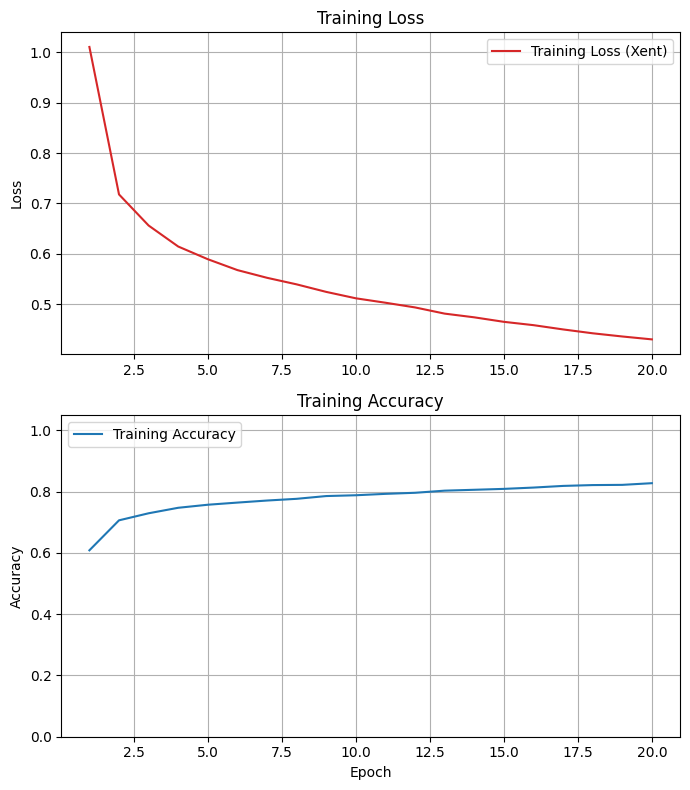

Final Training Loss:     0.4298
Final Training Accuracy: 0.8276

===== Training with learning_rate = 0.0005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5257 - loss: 1.2109
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6683 - loss: 0.8114
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6982 - loss: 0.7388
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7153 - loss: 0.6955
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7251 - loss: 0.6654
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7343 - loss: 0.6415
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7422 - loss: 0.6210
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7509 - loss: 0.6032
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7572 - loss: 0.5865
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7608 - loss: 0.5720
Epoch 11/20
481/481 ━━━━━

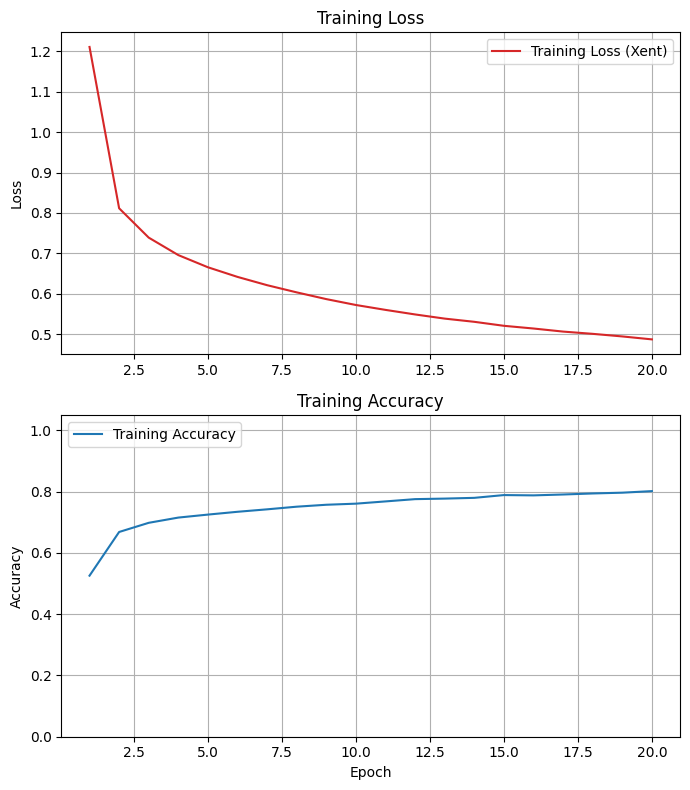

Final Training Loss:     0.4868
Final Training Accuracy: 0.8017

===== Training with learning_rate = 0.0001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3382 - loss: 1.7663
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5580 - loss: 1.2678
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5952 - loss: 1.0189
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6243 - loss: 0.9158
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6489 - loss: 0.8603
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6676 - loss: 0.8237
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6774 - loss: 0.7968
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6886 - loss: 0.7758
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6922 - loss: 0.7580
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7008 - loss: 0.7420
Epoch 11/20
481/481 ━━━━━

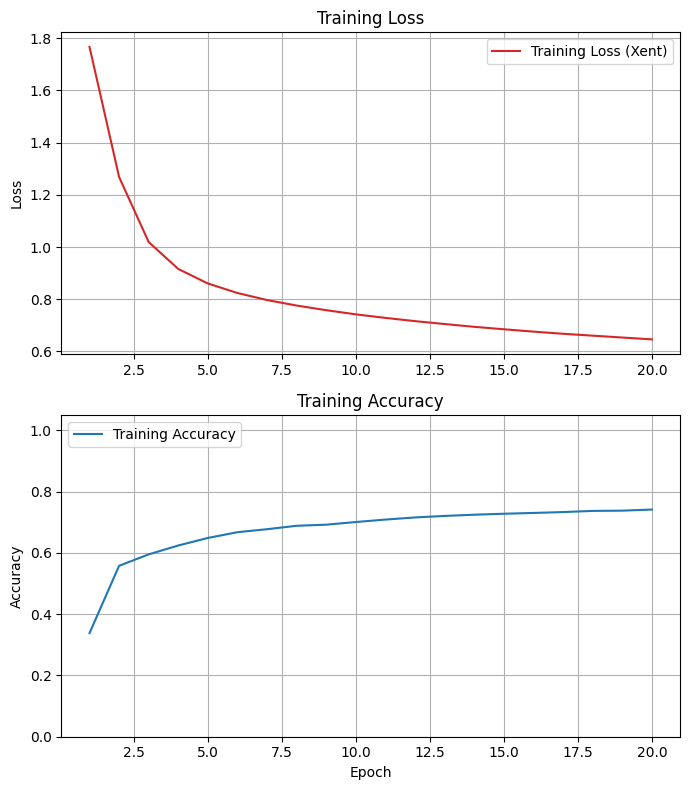

Final Training Loss:     0.6462
Final Training Accuracy: 0.7416

===== Training with learning_rate = 5e-05 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2335 - loss: 1.9007
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3917 - loss: 1.6079
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5022 - loss: 1.3739
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5728 - loss: 1.1956
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6037 - loss: 1.0718
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6172 - loss: 0.9947
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6275 - loss: 0.9453
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6380 - loss: 0.9109
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6466 - loss: 0.8851
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6514 - loss: 0.8648
Epoch 11/20
481/481 ━━━━━━

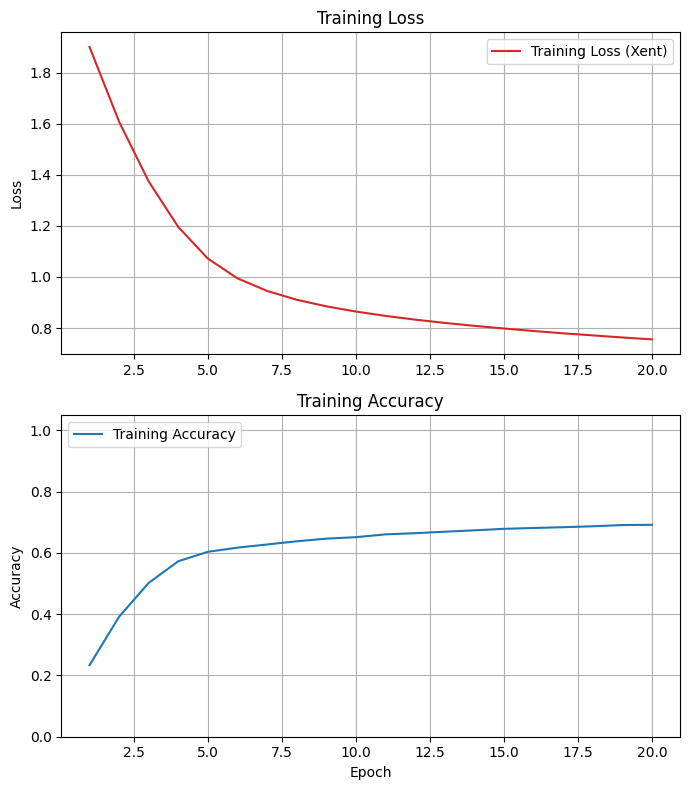

Final Training Loss:     0.7557
Final Training Accuracy: 0.6917

===== Training with learning_rate = 1e-05 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2214 - loss: 2.0137
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2447 - loss: 1.9147
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2830 - loss: 1.8332
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3587 - loss: 1.7622
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4027 - loss: 1.6979
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4264 - loss: 1.6380
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4508 - loss: 1.5814
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4724 - loss: 1.5277
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4908 - loss: 1.4770
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5059 - loss: 1.4292
Epoch 11/20
481/481 ━━━━━━

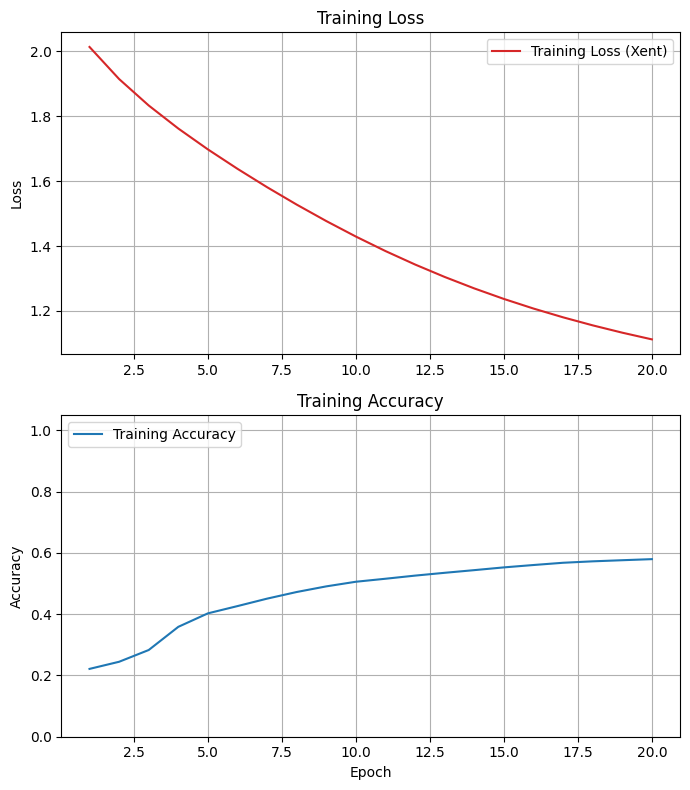

Final Training Loss:     1.1123
Final Training Accuracy: 0.5797


In [15]:
# Your code here

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
lr_histories = {}

for lr in learning_rates:
    tf.keras.backend.clear_session()  # fresh model each run

    # Build (same architecture as Problem One)
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with varying learning rate
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== Training with learning_rate = {lr} =====")
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,   # same as baseline
        verbose=1
    )

    lr_histories[lr] = history
    plot_history(history)




In [16]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 1e-3 

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [18]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.8276 

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8276


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


===== CosineDecay with initial_learning_rate = 0.01 =====
Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6536 - loss: 0.8268
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7126 - loss: 0.6750
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7362 - loss: 0.6303
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7547 - loss: 0.5889
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7670 - loss: 0.5646
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7785 - loss: 0.5343
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7878 - loss: 0.5123
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7905 - loss: 0.5061
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8076 - loss: 0.4664
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8202 - loss: 0.4439
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8272 - loss: 0.4218
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

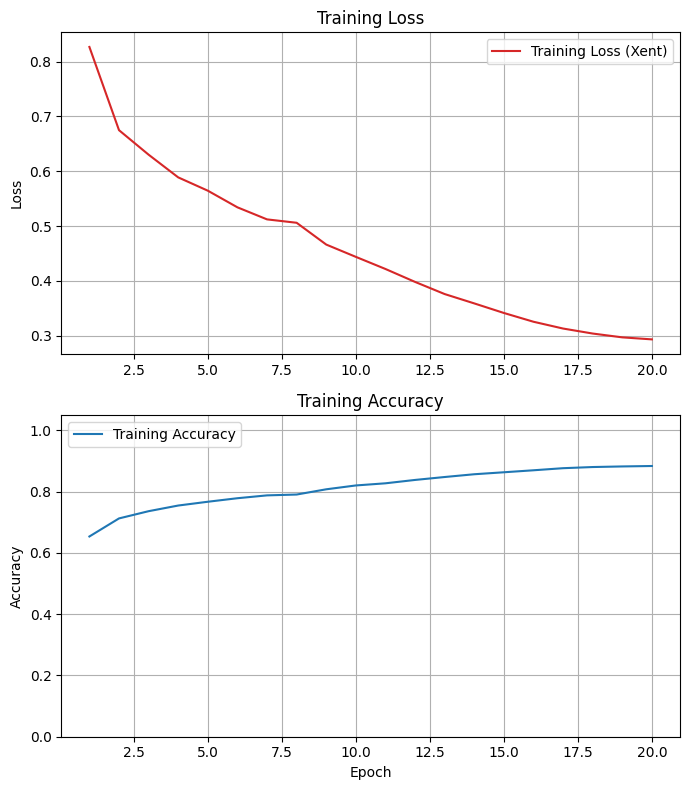

Final Training Loss:     0.2934
Final Training Accuracy: 0.8837

===== CosineDecay with initial_learning_rate = 0.005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6542 - loss: 0.8269
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7265 - loss: 0.6499
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7459 - loss: 0.6027
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7635 - loss: 0.5604
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7761 - loss: 0.5372
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7933 - loss: 0.5022
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8010 - loss: 0.4792
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8141 - loss: 0.4548
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8188 - loss: 0.4358
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8321 - loss: 0.4122
Epoch 11/20
481

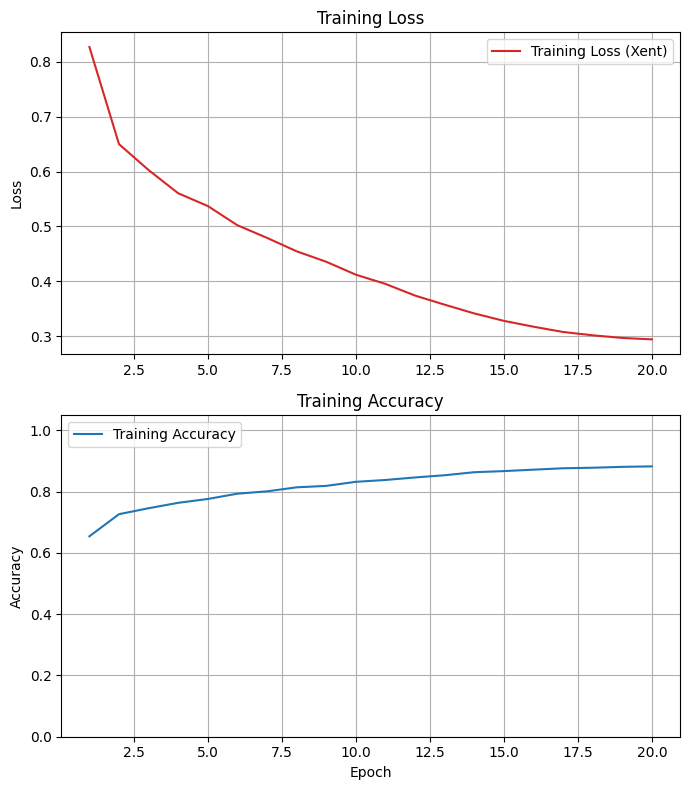

Final Training Loss:     0.2944
Final Training Accuracy: 0.8825

===== CosineDecay with initial_learning_rate = 0.001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5904 - loss: 1.0221
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6932 - loss: 0.7362
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7180 - loss: 0.6681
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7378 - loss: 0.6289
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7522 - loss: 0.5997
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7551 - loss: 0.5795
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7627 - loss: 0.5629
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7686 - loss: 0.5488
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7728 - loss: 0.5377
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7788 - loss: 0.5266
Epoch 11/20
481

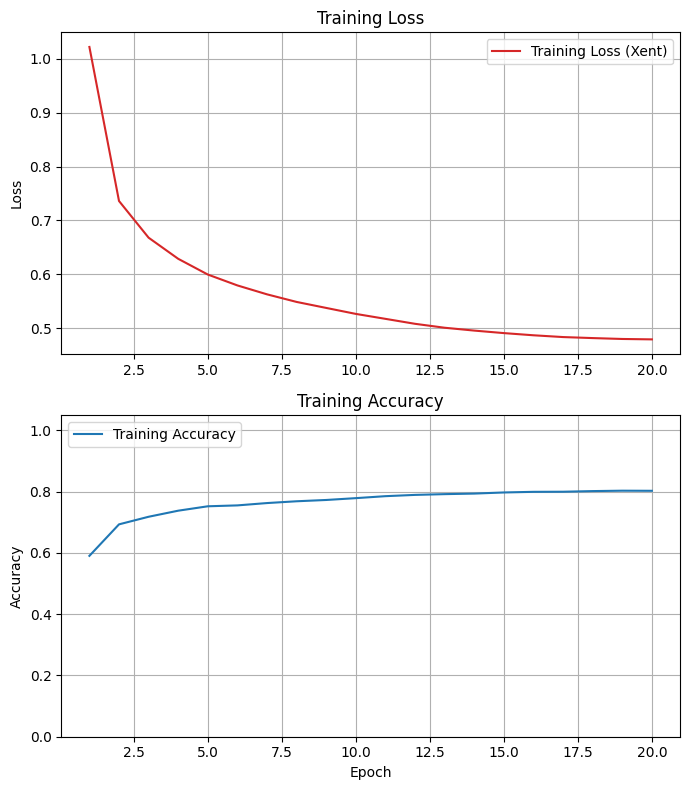

Final Training Loss:     0.4793
Final Training Accuracy: 0.8028

===== CosineDecay with initial_learning_rate = 0.0005 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5521 - loss: 1.2105
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6668 - loss: 0.8202
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6984 - loss: 0.7465
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7127 - loss: 0.6996
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7294 - loss: 0.6670
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7374 - loss: 0.6407
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7481 - loss: 0.6213
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7530 - loss: 0.6055
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7583 - loss: 0.5921
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7626 - loss: 0.5816
Epoch 11/20
48

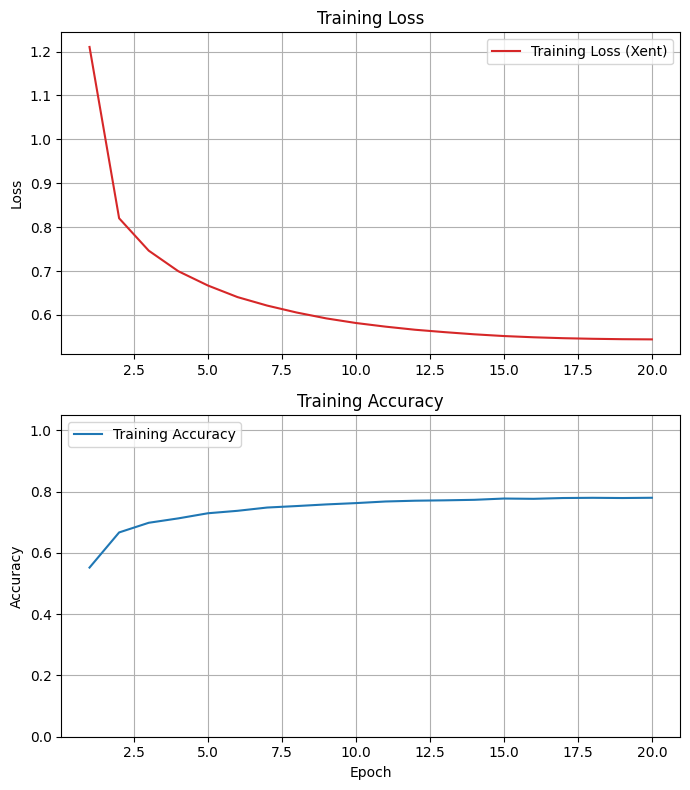

Final Training Loss:     0.5443
Final Training Accuracy: 0.7800

===== CosineDecay with initial_learning_rate = 0.0001 =====
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3282 - loss: 1.7527
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5425 - loss: 1.2863
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5847 - loss: 1.0590
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6125 - loss: 0.9573
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6343 - loss: 0.8999
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6472 - loss: 0.8623
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6567 - loss: 0.8359
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6617 - loss: 0.8169
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6694 - loss: 0.8021
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6758 - loss: 0.7904
Epoch 11/20
48

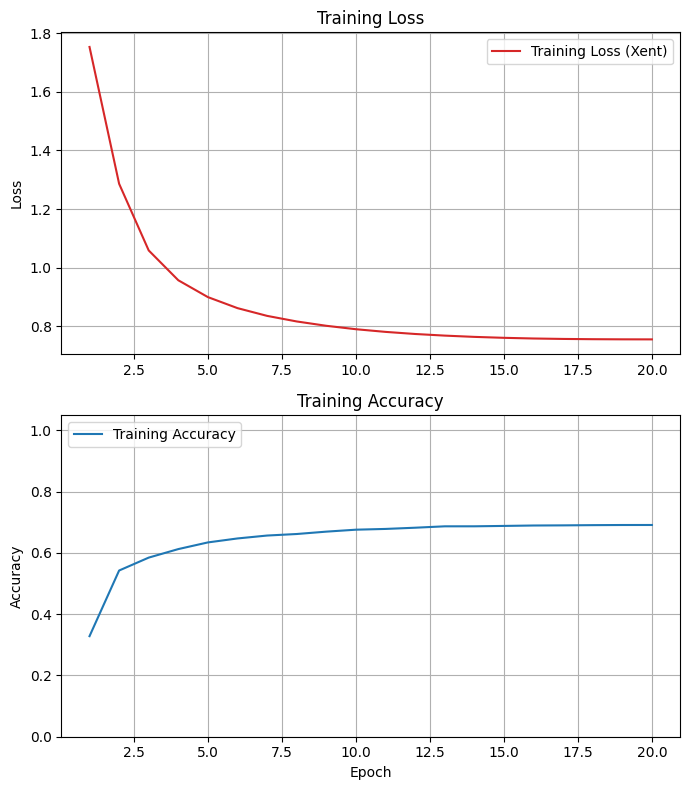

Final Training Loss:     0.7558
Final Training Accuracy: 0.6912


In [26]:
# Your code here

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
epochs = 20
batch_size = 32  

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
decay_steps = steps_per_epoch * epochs

cos_histories = {}

for init_lr in initial_lrs:
    tf.keras.backend.clear_session()

    # Cosine decay schedule
    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps
    )

    # Build baseline model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile with Adam using the schedule
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\n===== CosineDecay with initial_learning_rate = {init_lr} =====")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    cos_histories[init_lr] = history
    plot_history(history)


In [21]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 1e-2 

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [23]:
# Set a4b to the best accuracy found

a4b = 0.8858 

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8858


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6206 - loss: 0.9175
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6663 - loss: 0.7996
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6871 - loss: 0.7492
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7016 - loss: 0.7211
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7153 - loss: 0.6935
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7280 - loss: 0.6676
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7370 - loss: 0.6469
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7459 - loss: 0.6169
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7568 - loss: 0.5903
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7660 - loss: 0.5754
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7754 - loss: 0.5483
Epoch 12/20
3846/3846 ━━━━━━━━

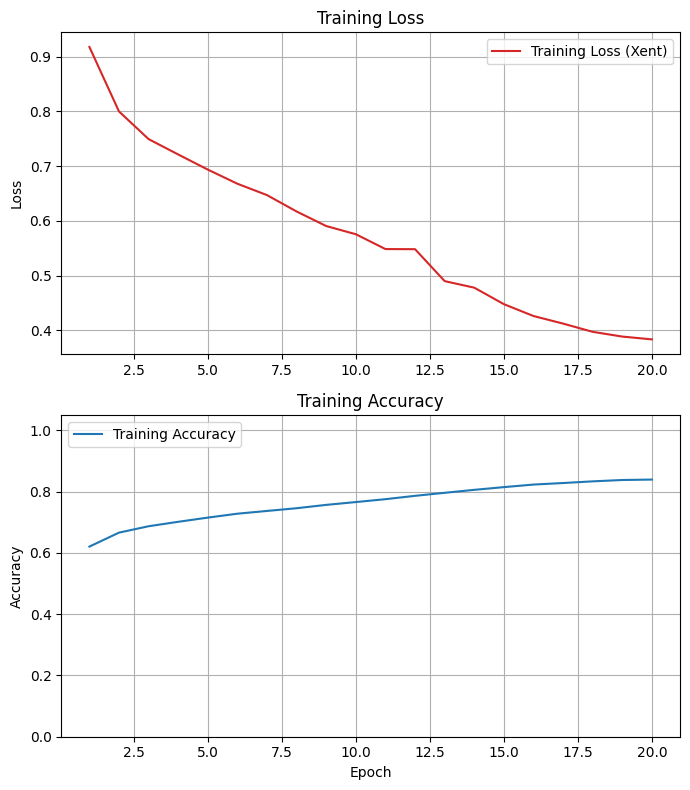

Final Training Loss:     0.3833
Final Training Accuracy: 0.8394
Test Loss: 0.4841
Test Accuracy: 0.8162


In [25]:
# Your code here -- add as many cells as you need

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

# Best hyperparams from your experiments
best_batch_size = 4
best_init_lr = 1e-2
epochs = 20

# decay_steps = steps_per_epoch * epochs
steps_per_epoch = int(np.ceil(len(X_train) / best_batch_size))
decay_steps = steps_per_epoch * epochs

lr_schedule = CosineDecay(
    initial_learning_rate=best_init_lr,
    decay_steps=decay_steps
)

tf.keras.backend.clear_session()

# SAME architecture as required: input -> 64 -> 32 -> 7
best_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

best_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_best = best_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=best_batch_size,
    verbose=1
)

# Plot training curves
plot_history(history_best)

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


In [27]:
# Set a5a to the best training accuracy found by your best model

a5a = 4

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 4.0000


In [29]:
# Set a5b to the test accuracy found by your best model

a5b = 1e-2  

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.0100


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


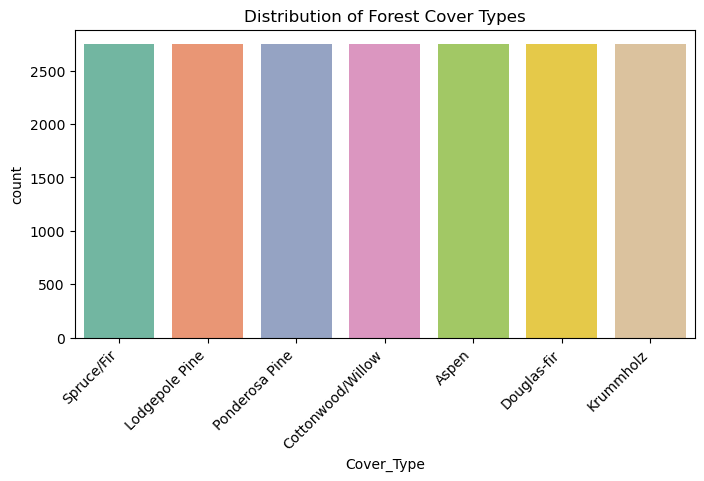

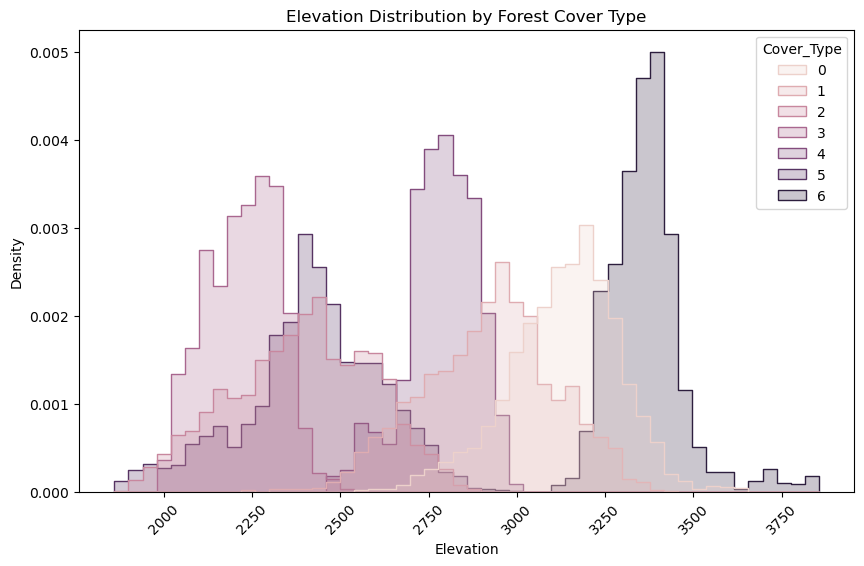

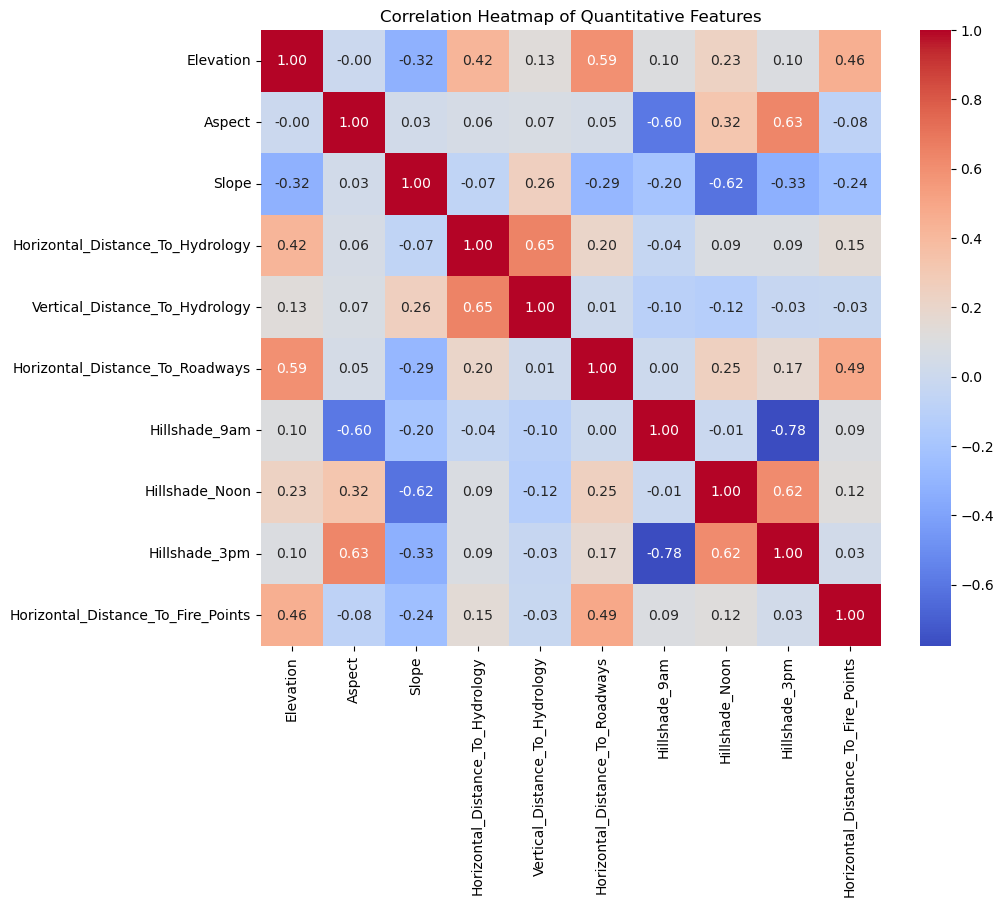

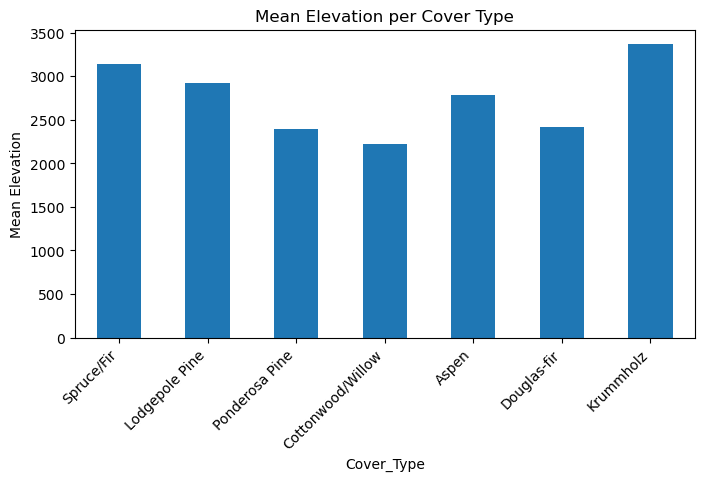

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
